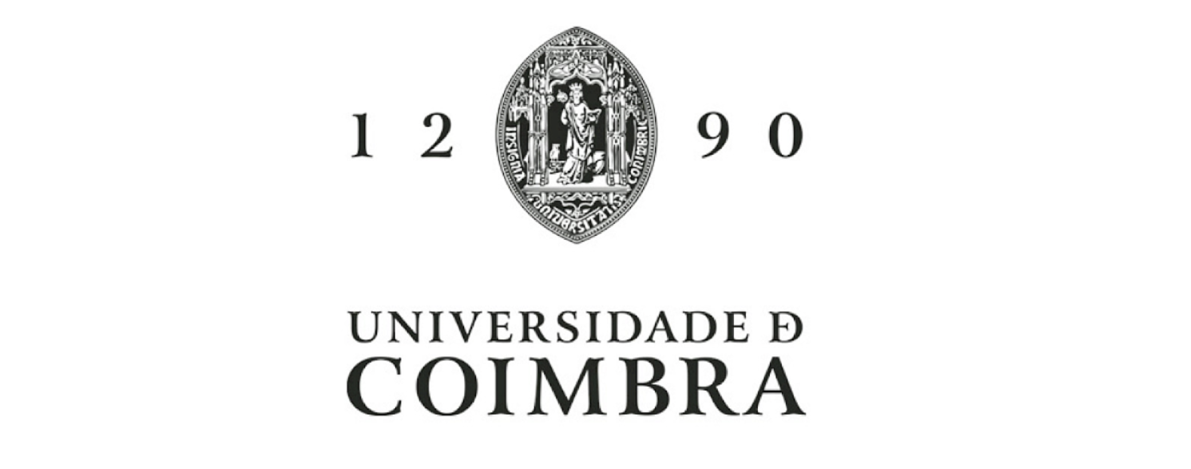

# LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt
from IPython.display import display, HTML 
import warnings
warnings.filterwarnings('ignore')


# ADVANCED FULL PIPELINE: GRIDSEARCHCV, FEATURE ENGINEERING, AND SHAP EXPLAINABILITY

# 1. LOAD DATA

In [ ]:
print("Loading data...")
file_path = 'dataset.csv'

try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded '{file_path}'")
except FileNotFoundError:
    print(f"ERROR: Could not find the file '{file_path}'.")
    # Create dummy data for demonstration if file is missing (Optional fallback)
    # remove this block in production
    data = {
        'encounter_id': range(100), 'patient_id': range(100), 'race': np.random.choice(['Caucasian', 'AfricanAmerican'], 100),
        'gender': np.random.choice(['Male', 'Female'], 100), 'age': np.random.choice(['[0-10)', '[50-60)'], 100),
        'weight': np.random.choice(['?', '[75-100)'], 100), 'number_inpatient': np.random.randint(0, 5, 100),
        'number_emergency': np.random.randint(0, 5, 100), 'number_outpatient': np.random.randint(0, 5, 100),
        'diag_1': np.random.randint(250, 800, 100), 'diag_2': np.random.randint(250, 800, 100), 'diag_3': np.random.randint(250, 800, 100),
        'diag_4': 0, 'diag_5': 0, 'medical_specialty': 'Other', 'change': 'No', 'diabetesMed': 'Yes',
        'readmitted': np.random.choice([0, 1], 100)
    }
    for i in range(1, 26): data[f'X{i}'] = 'No'
    df = pd.DataFrame(data)
    df['index'] = range(100)
    print("WARNING: Using generated dummy data for demonstration.")
except Exception as e:
    print(f"An error occurred loading the file: {e}")
    raise


# 2. PREPROCESSING

In [ ]:
print("Preprocessing...")

# Drop index, encounter_id, and patient_id
#Dropping columns: Removes ID columns. These are unique identifiers for database management but have no predictive value for a medical diagnosis.
if 'index' in df.columns: df = df.drop(['index', 'encounter_id', 'patient_id'], axis=1)

# Handle weight
#Handles missing values (?) and converts ranges like [0-25) into a single number
df['weight'] = df['weight'].replace('?', np.nan)
df['weight'] = df['weight'].str.replace('[', '', regex=False).str.replace(')', '', regex=False).str.split('-').str[0]
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')

# Handle age
#Converts categorical age ranges into a single numeric representative (the midpoint). For example, the range 10-20 becomes the number 15.
age_map = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
    '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}
df['age'] = df['age'].map(age_map)

# Diagnosis Grouping

# The Problem: Diagnosis codes (ICD-9) are very specific (e.g., 428.1, 428.2). 
# Using them directly creates hundreds of confusing features.

#The Solution: This section defines a function group_diagnosis 
# that groups these codes into high-level categories based on medical standards
print("Grouping diagnosis codes into categories...")
diag_cols = ['diag_1', 'diag_2', 'diag_3']

for col in diag_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.extract('(\d+)')[0], errors='coerce')

def group_diagnosis(icd9_code):
    if pd.isna(icd9_code): return 'Missing'
    icd9_code = float(icd9_code)
    if (icd9_code >= 390 and icd9_code <= 459) or icd9_code == 785: return 'Circulatory'
    if (icd9_code >= 460 and icd9_code <= 519) or icd9_code == 786: return 'Respiratory'
    if (icd9_code >= 520 and icd9_code <= 579) or icd9_code == 787: return 'Digestive'
    if icd9_code == 250: return 'Diabetes'
    if icd9_code >= 800 and icd9_code <= 999: return 'Injury'
    if icd9_code >= 710 and icd9_code <= 739: return 'Musculoskeletal'
    if icd9_code >= 580 and icd9_code <= 629 or icd9_code == 788: return 'Genitourinary'
    if icd9_code >= 140 and icd9_code <= 239: return 'Neoplasms'
    return 'Other'

for col in diag_cols:
    df[col] = df[col].apply(group_diagnosis)


#Drops the 4th and 5th diagnosis codes to reduce noise and focus on the primary ailments.
df = df.drop(['diag_4', 'diag_5'], axis=1, errors='ignore')

# Handle Medications
med_cols = [f'X{i}' for i in range(1, 26)]
for col in ['X1', 'X2']:
    df[col] = df[col].replace('None', 0)
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
#This numeric mapping helps the model understand that "Up" and "Down" are opposites.
change_map = {'No': 0, 'Up': 1, 'Down': -1, 'Steady': 0}
for col in med_cols[2:]:
    df[col] = df[col].map(change_map).fillna(0)

# Categorical Encoding
#Converts text categories (like "Male"/"Female" or "Circulatory"/"Diabetes") into machine-readable numbers (0, 1, 2, 3...).
cat_cols = ['race', 'gender', 'medical_specialty', 'change', 'diabetesMed', 'diag_1', 'diag_2', 'diag_3']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna('missing')
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Fill NaNs
df = df.fillna(df.median(numeric_only=True))

# Feature Engineering
# total_visits: Sums inpatient, emergency, and outpatient visits to gauge how often the patient interacts with the hospital.
# med_changes: Counts how many medications were changed (Up/Down). This is a strong indicator of an unstable medical condition.
print("Creating total_visits and med_changes features...")
df['total_visits'] = df['number_inpatient'] + df['number_emergency'] + df['number_outpatient']
med_change_cols = [f'X{i}' for i in range(3, 26)]
df['med_changes'] = (df[med_change_cols] != 0).sum(axis=1)

# Target
y = df['readmitted']
X = df.drop('readmitted', axis=1)

# 3. TRAIN-TEST SPLIT

Splits the data: 80% for training the model, 20% for testing it.

stratify=y: Ensures that if 10% of patients are readmitted in the total data, exactly 10% are readmitted in both the training and test sets.

In [ ]:
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. HYPERPARAMETER TUNING

Initializes the Random Forest. `class_weight='balanced'` is crucial here because it tells the model to pay extra attention to the minority class (Readmitted patients), preventing it from ignoring them.

Grid Search: Instead of guessing the settings, this tool tests combinations.

It tries 100 trees with depth 10, then 100 trees with depth 20, etc.

`cv=3`: Splits the training data into 3 parts to validate each combination internally.

`grid_search.fit`: Runs the training loops.

`model = grid_search.best_estimator_`: Saves the version of the model that performed best.

In [ ]:
print("Starting Hyperparameter Tuning ")

rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]} # Reduced for speed in example

grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=3,
    scoring='f1_weighted', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_

print(f"\nBest f1_weighted score: {grid_search.best_score_:.4f}")

# 5. SHAP EXPLAINABILITY

Calculates the "contribution" of every feature for every patient in the sample.

In [ ]:

print("Computing SHAP values...")
# Sample 100 for speed
X_test_sample = X_test.sample(n=100, random_state=42)

shap.initjs()
explainer = shap.TreeExplainer(model)
explanation_object = explainer(X_test_sample)

# 6. SHAP PLOTS

In [ ]:

print("\n--- Generating SHAP Plots ---")
explanation_class_1 = explanation_object[:, :, 1]

# ---  Interactive Force Plot (Single Prediction) ---
print("Displaying Interactive Force Plot (for first prediction, Class 1)...")
# We capture the plot object
force_plot_1 = shap.force_plot(explanation_object[0, :, 1])
# We wrap the .html() output in a white Div
display(HTML(f"<div style='background-color: white; padding: 10px;'>{force_plot_1.html()}</div>"))

# --- Interactive Force Plot (All Samples) ---
print("\nDisplaying Interactive Force Plot (for ALL samples, Class 1)...")
# We capture the plot object
force_plot_all = shap.force_plot(explanation_class_1)
# We wrap the .html() output in a white Div
display(HTML(f"<div style='background-color: white; padding: 10px;'>{force_plot_all.html()}</div>"))

# --- Static Matplotlib Plots (White Backgrounds) ---
print("\nGenerating Waterfall Plot...")
# Use facecolor='white' for the static figure
plt.figure(facecolor='white') 
shap.waterfall_plot(explanation_class_1[0], max_display=10, show=False)
plt.show()

print("\nGenerating Feature Importance (Bar Plot)...")
plt.figure(facecolor='white')
shap.summary_plot(explanation_class_1, plot_type="bar", max_display=15, show=False)
plt.show()

print("\nGenerating Beeswarm Plot...")
plt.figure(facecolor='white')
shap.summary_plot(explanation_class_1, max_display=15, show=False)
plt.show()

print("\nGenerating Dependence Plots...")
shap_values_class_1 = explanation_class_1.values
feature_names = explanation_class_1.feature_names
top_features_indices = np.argsort(np.abs(shap_values_class_1).mean(0))[-3:][::-1]

for i, idx in enumerate(top_features_indices):
    plt.figure(facecolor='white') # Ensure white background
    print(f"Plotting dependence for: {feature_names[idx]}")
    shap.dependence_plot(
        feature_names[idx], 
        shap_values_class_1, 
        X_test_sample,
        show=False
    )
    plt.show()

# 7. TOP 10 IMPORTANT FEATURES

Loading data...
Successfully loaded 'dataset.csv'
Preprocessing...
Grouping diagnosis codes into categories...
Creating total_visits and med_changes features...
Splitting data...
Starting Hyperparameter Tuning (this may take 5-10 minutes)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best f1_weighted score: 0.7295
Computing SHAP values...



--- Generating SHAP Plots ---
Displaying Interactive Force Plot (for first prediction, Class 1)...



Displaying Interactive Force Plot (for ALL samples, Class 1)...



Generating Waterfall Plot...


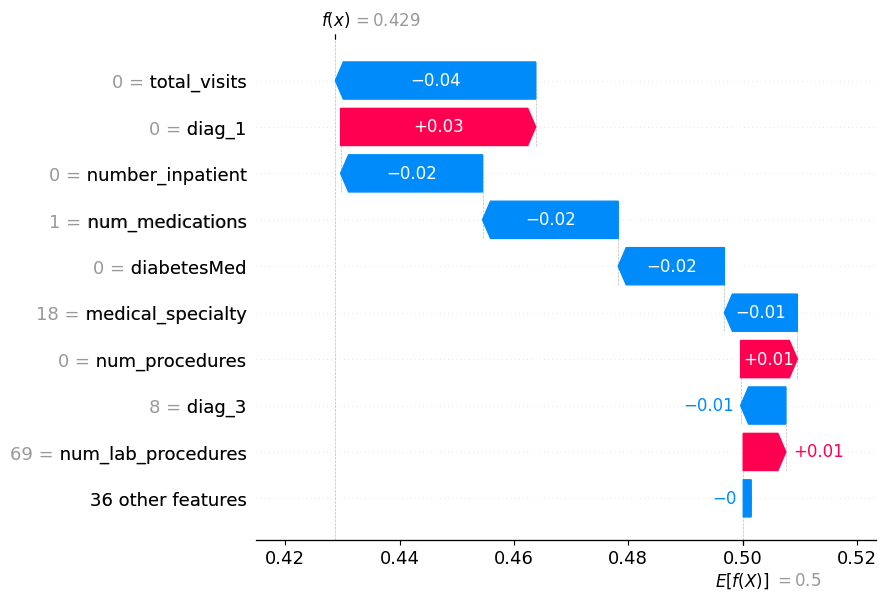


Generating Feature Importance (Bar Plot)...


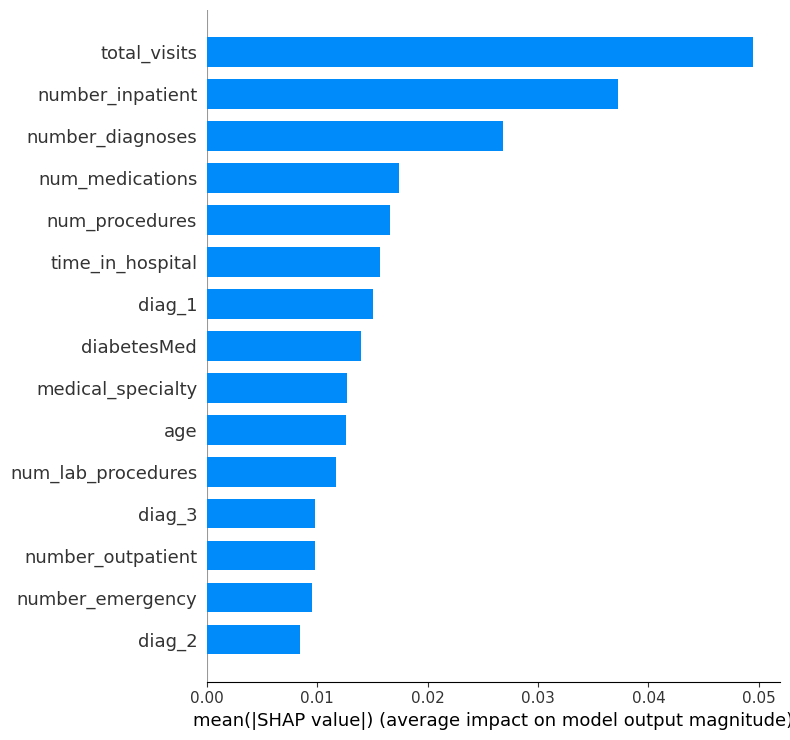


Generating Beeswarm Plot...


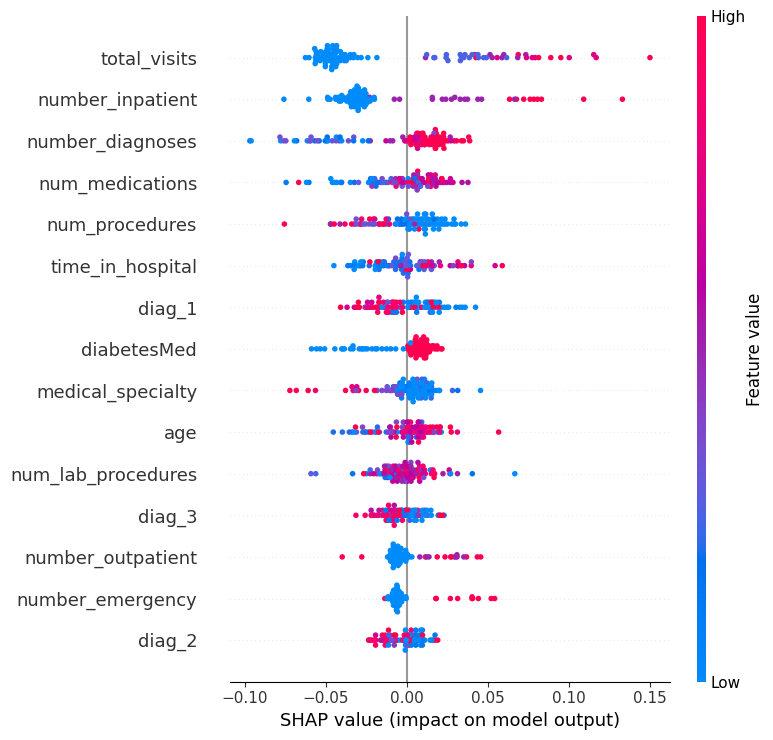


Generating Dependence Plots...
Plotting dependence for: total_visits


<Figure size 640x480 with 0 Axes>

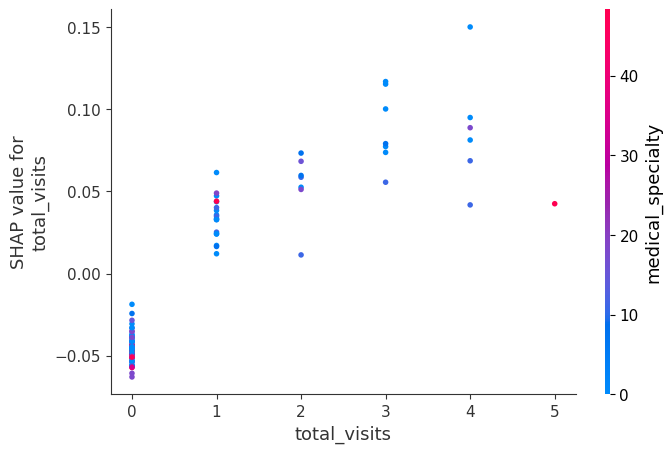

Plotting dependence for: number_inpatient


<Figure size 640x480 with 0 Axes>

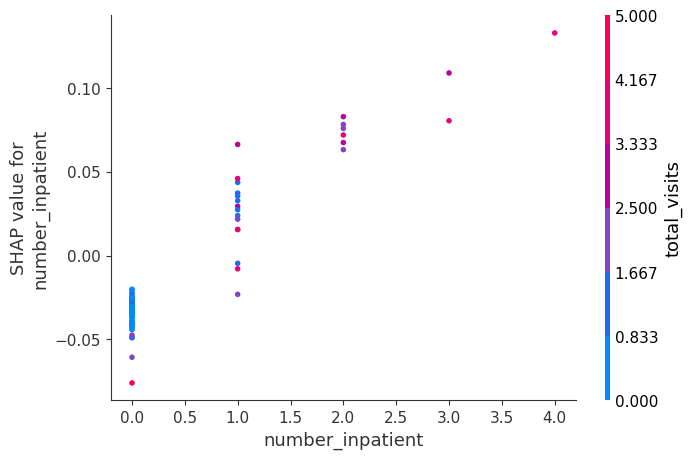

Plotting dependence for: number_diagnoses


<Figure size 640x480 with 0 Axes>

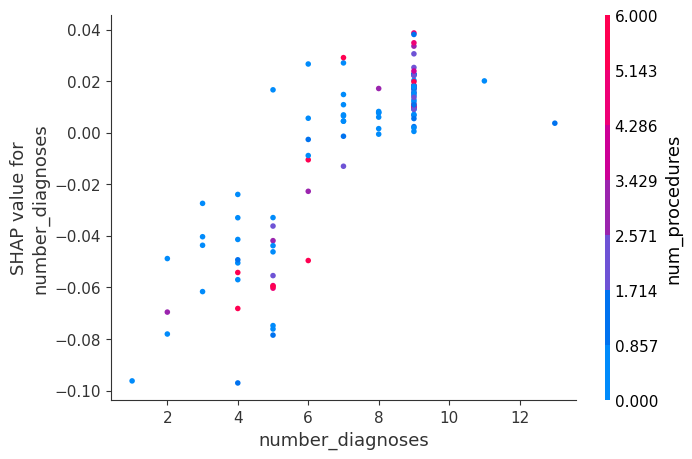


Top 10 Most Important Features (by mean |SHAP|):
          feature  importance
     total_visits    0.049442
 number_inpatient    0.037245
 number_diagnoses    0.026788
  num_medications    0.017434
   num_procedures    0.016609
 time_in_hospital    0.015641
           diag_1    0.015061
      diabetesMed    0.013963
medical_specialty    0.012653
              age    0.012579


In [ ]:

print("\nTop 10 Most Important Features (by mean |SHAP|):")
shap_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values_class_1).mean(0)
}).sort_values('importance', ascending=False)
print(shap_importance.head(10).to_string(index=False))

### Example of a Waterfall Plot for non-readmitted patient.


Generating Waterfall Plot...


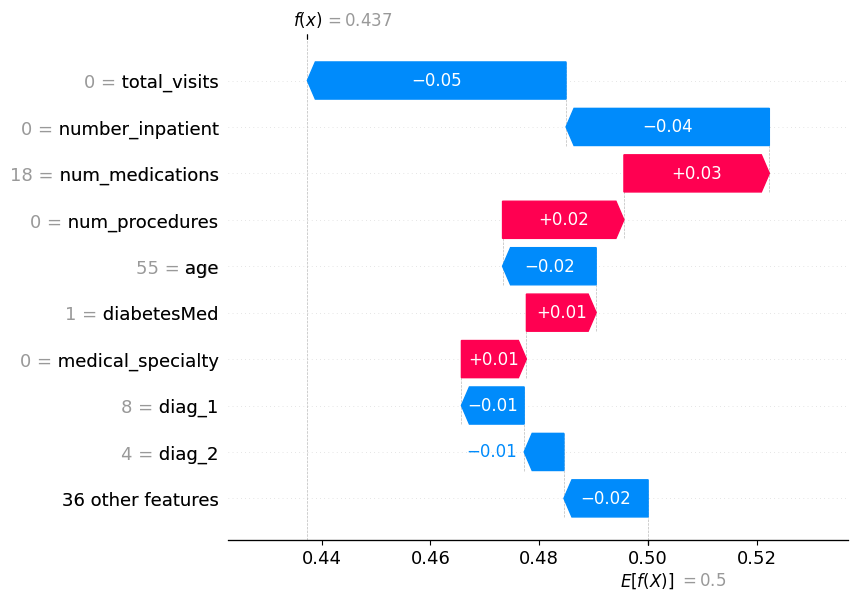

In [2]:
print("\nGenerating Waterfall Plot...")
plt.figure()
shap.waterfall_plot(explanation_class_1[1], max_display=10, show=False)
plt.show()


### Example of a Waterfall Plot for a readmitted patient.


Generating Waterfall Plot...


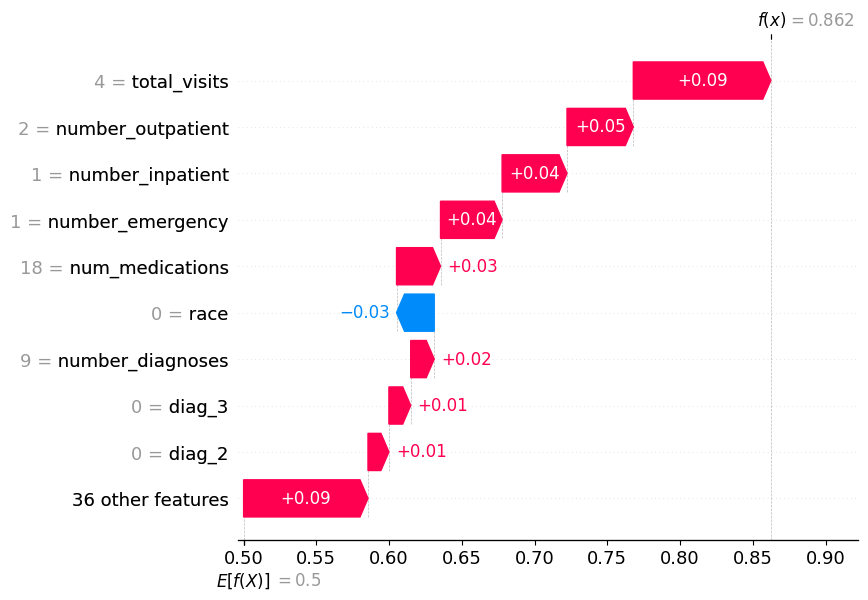

In [3]:
print("\nGenerating Waterfall Plot...")
plt.figure()
shap.waterfall_plot(explanation_class_1[4], max_display=10, show=False)
plt.show()

### Example of a Waterfall Plot for a non-readmitted patient.


Generating Waterfall Plot...


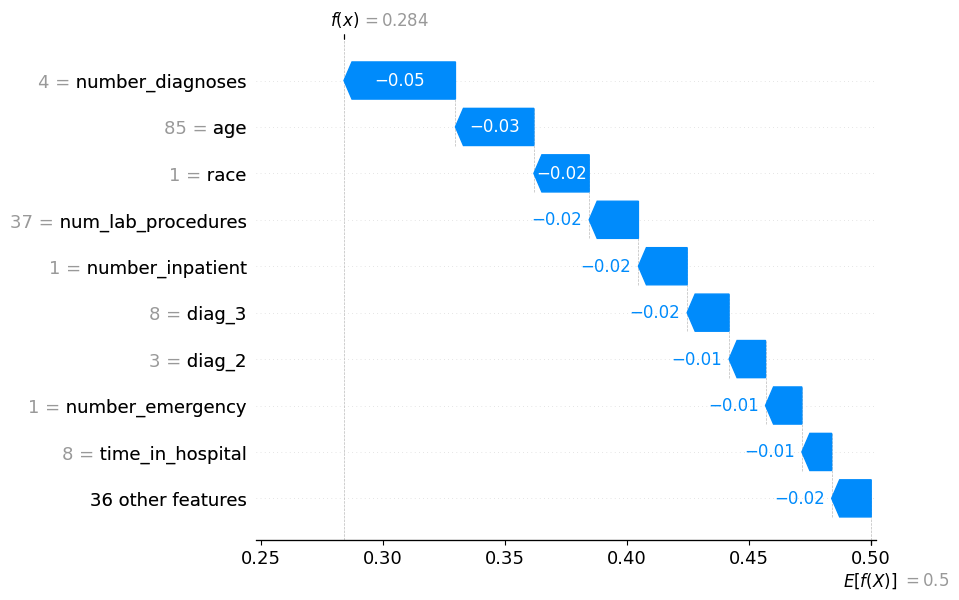

In [4]:
print("\nGenerating Waterfall Plot...")
plt.figure()
shap.waterfall_plot(explanation_class_1[3], max_display=10, show=False)
plt.show()


# FULL LIST OF FEATURES

In [ ]:

print("\n Importantance Features (by mean |SHAP|):")
shap_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values_class_1).mean(0)
}).sort_values('importance', ascending=False)
print(shap_importance.head(30).to_string(index=False))


Top 10 Most Important Features (by mean |SHAP|):
           feature  importance
      total_visits    0.048047
  number_inpatient    0.038253
  number_diagnoses    0.026417
   num_medications    0.017589
    num_procedures    0.016327
  time_in_hospital    0.015775
            diag_1    0.014705
       diabetesMed    0.014351
 medical_specialty    0.012547
               age    0.012038
num_lab_procedures    0.011362
 number_outpatient    0.009787
            diag_3    0.009696
  number_emergency    0.009654
            diag_2    0.008395
              race    0.008330
       med_changes    0.005141
            change    0.005051
            gender    0.004773
               X20    0.003726
            weight    0.000482
                X9    0.000227
                X3    0.000219
               X10    0.000190
                X7    0.000095
               X13    0.000076
               X12    0.000064
                X4    0.000031
               X14    0.000025
               X21  